# Risk Management Framework

Draws heavily from Fortin & al (2023)

By Nicolas Harvie
Update: Full project in R
***

In [1]:
import numpy as np 
import pandas as pd 
import pandas_datareader as pdr 
import scipy.stats as stats
import arch.univariate as arch
from datetime import datetime, timedelta
import sys
from statsmodels.sandbox.stats.runs import runstest_1samp 
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image


***
## Univariate Model

### Data

In [2]:
returns_stocks = pd.read_csv('../data/returns.csv', parse_dates=['DlyCalDt'])

returns_stocks = returns_stocks.groupby(['DlyCalDt', 'Ticker']).mean().reset_index()
returns_stocks = returns_stocks.pivot(index='DlyCalDt', columns='Ticker', values='DlyRet')

In [3]:
returns_stocks

Ticker,BA,CAT,CVX,GE,IBM,KO,MRK,PG,UTX,XOM
DlyCalDt,,,,,,,,,,
1963-07-05,-0.003497,NaN,-0.003759,-0.001550,0.007357,0.004011,0.028302,0.011401,-0.003559,NaN
1963-07-08,-0.010526,NaN,0.007547,-0.003106,-0.020225,0.001332,-0.017038,-0.004831,-0.003571,NaN
1963-07-09,0.003546,NaN,0.007491,0.003115,0.011181,0.010638,0.013333,-0.001618,-0.010753,NaN
1963-07-10,-0.003534,NaN,-0.003717,-0.007764,-0.008789,0.001316,0.000000,-0.001621,-0.014493,NaN
1963-07-11,-0.003546,NaN,-0.007463,-0.001565,-0.006865,-0.001314,-0.005263,0.004870,-0.014706,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.013479,-0.006869,0.000083,0.002688,-0.004205,-0.003642,-0.003270,0.002562,-0.001669,-0.003841
2019-12-26,-0.009249,0.005018,0.002161,0.003575,-0.000519,0.005666,-0.001094,0.000000,0.007622,0.001571
2019-12-27,0.000667,0.000405,-0.002488,-0.004452,0.002668,0.005998,0.001752,0.006948,-0.002853,-0.003422


In [4]:
log_returns_stocks = np.log(1+returns_stocks)
weekly_logrets = log_returns_stocks.resample('W').sum()

#### Factor Returns

In [5]:
# FF Specifications
FF_MOM_with_rf= pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1963-07-07', end='2019-12-31')[0]
FF_MOM_with_rf['MOM'] = pdr.get_data_famafrench('F-F_Momentum_Factor_daily', start='1963-07-07', end='2019-12-31')[0]
FF_three_without_rf = FF_MOM_with_rf.drop(columns={'RF'})

# Percentage Returns
FF_three_without_rf_pct = FF_three_without_rf / 100

# Converting the factors returns to log for additivity
FF_three_without_rf_log = np.log(1 + FF_three_without_rf_pct)

## Resampling to Weekly Frequency 
FF_three_without_rf_log_weekly = FF_three_without_rf_log.resample('W').sum()

In [6]:
FF_three_without_rf

,Mkt-RF,SMB,HML,MOM
Date,,,,
1963-07-08,-0.63,0.06,-0.20,-0.45
1963-07-09,0.45,0.03,0.09,0.44
1963-07-10,-0.18,0.16,0.00,0.16
1963-07-11,-0.16,0.18,-0.29,-0.12
1963-07-12,-0.12,0.02,-0.09,-0.17
...,...,...,...,...
2019-12-24,0.01,0.39,-0.01,0.16
2019-12-26,0.48,-0.54,0.00,0.30
2019-12-27,-0.10,-0.53,-0.07,0.37


In [8]:
# Replication of Table 1 
to_table_ff = FF_three_without_rf_log_weekly
desc_stats_factors = FF_three_without_rf_log_weekly.describe(percentiles=[.5]).T.drop(columns={'count'})
desc_stats_factors.loc[:, 'skew'] = FF_three_without_rf_log_weekly.skew().tolist()
desc_stats_factors.loc[:, 'kurt'] = FF_three_without_rf_log_weekly.kurtosis().tolist()
desc_stats_factors

,mean,std,min,50%,max,skew,kurt
Mkt-RF,0.001013,0.021750,-0.198295,0.002796,0.126307,-0.703581,6.183253
SMB,0.000203,0.012222,-0.102115,0.000483,0.068037,-0.515501,6.277997
HML,0.000670,0.012264,-0.103120,0.000195,0.091391,0.306618,7.519978
MOM,0.001322,0.018282,-0.171654,0.002273,0.119114,-1.387890,12.023491


In [9]:
desc_stats_stocks = weekly_logrets.describe(percentiles=[.5]).T.drop(columns={'count'})
desc_stats_stocks.loc[:, 'skew'] = weekly_logrets.skew().tolist()
desc_stats_stocks.loc[:, 'kurt'] = weekly_logrets.kurtosis().tolist()
desc_stats_stocks

,mean,std,min,50%,max,skew,kurt
Ticker,,,,,,,
BA,0.002648,0.044820,-0.367317,0.003425,0.202940,-0.257751,3.408660
CAT,0.001649,0.039576,-0.294040,0.000000,0.269243,-0.084987,3.965405
CVX,0.001260,0.024414,-0.316738,0.000000,0.154665,-0.737893,12.952186
GE,0.001478,0.035871,-0.228877,0.001166,0.309399,0.032001,5.951187
IBM,0.001543,0.033229,-0.194013,0.001392,0.177024,-0.143327,3.194125
KO,0.002366,0.031857,-0.327098,0.002371,0.230682,-0.503489,7.055279
MRK,0.002363,0.035282,-0.280603,0.001857,0.174300,-0.360943,3.763956
PG,0.002110,0.029507,-0.500281,0.001467,0.137783,-1.743428,30.259969
UTX,0.002362,0.033764,-0.449075,0.000000,0.149885,-1.089858,13.770434


### Creation of Randomly Weighed Portfolio

"That is, we generate weights using a uniform distribution, with each weight between zero and one,and a sum of weights equal to one. The same sets of portfolio weights are applied to the univariate and multivariate models." (Fortin, 2022, 7)

In [10]:
###=== FUNCTION TO GENERATE RANDOMLY WEIGHTED PORTFOLIO RETURNS TIMESERIES ===###

def create_randomly_weighted_portfolios(returns_df, n_ports, resample=None): 

    # Random weighings where size is equivalent to the number of portfolios  
    n_assets = len(returns_df.columns)

    # Weights Matrix 
    weights_matrix = np.random.dirichlet(np.ones(n_assets), size=n_ports)
    
    # First Portfolio is Equally weighed 
    portfolio_set = returns_df @ np.array([1/n_assets] * n_assets).T
    portfolio_set = pd.DataFrame(portfolio_set, columns=['EW'])

    # Loop that outs the returns for every set of portfolio weights
    for i, weights in enumerate(range(len(weights_matrix))):
        portfolio_set['R' + str(i+1)] = pd.DataFrame(returns_df @ weights_matrix[weights].T)

    # Logarized Portfolio 
    log_portfolio_set = np.log(1 + portfolio_set)

    if resample == 'Weekly':
        portfolio_set = log_portfolio_set.resample('W').sum()
    if resample == 'Monthly':
        portfolio_set = log_portfolio_set.resample('M').sum()

    return portfolio_set

In [11]:
log_portfolio_set_weekly = create_randomly_weighted_portfolios(weekly_logrets, 10, resample=None)

## VaR Estimation

### By hand

In [14]:
res_example = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='Constant',
vol='GARCH', p=1, o=0, q=1, dist='Normal').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5333332322.558798
Iteration:      2,   Func. Count:     18,   Neg. LLF: 7.090943070002066e+19
Iteration:      3,   Func. Count:     30,   Neg. LLF: 427578166763696.5
Iteration:      4,   Func. Count:     43,   Neg. LLF: -7544.985499139744
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7544.985493523915
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4


In [15]:
###=== ESTIMATE THE NEXT PERIOD VARIANCE ===###
def estimate_future_variance(s,res_object, return_LRV=False):
    
    w = res_object.params.loc['omega']
    a = res_object.params.loc['alpha[1]']
    b = res_object.params.loc['beta[1]']
    
    last_period_obs = s[-1]

    # Square root of conditional variance
    last_period_volatility = res_object.conditional_volatility[-1]

    next_period_variance = w + (a*(last_period_obs**2)) + (b*(last_period_volatility**2))
    # Estimation of the LRV (might be useful in some cases)
    LRV = w / (1 - a - b)

    # if return_LRV == True: 
    #next_period_variance = LRV + a*(last_period_obs**2 - LRV) + b*(last_period_volatility**2 - LRV)

    return next_period_variance


In [16]:
by_hand_variance = estimate_future_variance(log_portfolio_set_weekly['EW'], res_example)

print(f'HAND Conditional t+1 Variance is: {by_hand_variance}')
print(f'HAND Conditional t+1 Volatility is: {np.sqrt(by_hand_variance)}')

HAND Conditional t+1 Variance is: 0.0001654919502747461
HAND Conditional t+1 Volatility is: 0.012864367465007602


***
## Forecasting Future Variance

### Models 

In [17]:
# CONSTANT MODELS 
# We found that skewt innovations would create convergence problems
# Hence why we are not using them at the moment
am_garch = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='Constant',
vol='GARCH', p=1, o=0, q=1, dist='Normal')
am_gjr = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='Constant',
vol='GARCH', p=1, o=1, q=1, dist='Normal')
am_egarch = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='Constant',
vol='EGARCH', p=1, o=0, q=1, dist='Normal')

# ARX MODELS
am_argarch = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='ARX', lags=3,
vol='GARCH', p=1, o=0, q=1, dist='Normal')
am_argjr = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='ARX', lags=3,
vol='GARCH', p=1, o=1, q=1, dist='Normal')
am_aregarch = arch.arch_model(y = log_portfolio_set_weekly['EW'], mean='ARX', lags=3,
vol='EGARCH', p=1, o=0, q=1, dist='Normal')

In [18]:
###=== FUNCTION TO ESTIMATE THE ONE PERIOD AHEAD RISK MEASURES ===###
def estimate_future_risk(res_object, q, horizon):

    # Variance forecast t+h  
    forecast = res_object.forecast(reindex=True, horizon=horizon)

    # Conditional Volatility
    forecast_variance = float(forecast.variance.values[-1][-1])
    forecast_condvol = np.sqrt(forecast_variance)

    # FHS 
    std_rets = res_object.resid / res_object.conditional_volatility
    std_rets = std_rets.dropna()

    fhs_VaR = std_rets.quantile(q) * forecast_condvol
    fhs_ES = np.mean(res_object.resid[res_object.resid <= fhs_VaR])

    # Forecast Based on distribution assumption
    if res_object.model.distribution.name == "Standardized Skew Student's t":
        t = res_object.params.loc['eta']
        l = res_object.params.loc['lambda']
        mult = res_object.model.distribution.ppf(q, parameters=[t, l]) 
        VaR = mult * forecast_condvol

        # ES computation made by simulation 
        sim_returns = arch.SkewStudent().simulate(parameters=[res_object.params[-2:]])(size=100000) * forecast_condvol
        ES = np.mean(sim_returns[sim_returns < np.quantile(sim_returns, q)])

    elif res_object.model.distribution.name == "Standardized Student's t":
        df = res_object.params.loc['nu']
        mult = res_object.model.distribution.ppf(q, parameters=[df])
        VaR =  mult * forecast_condvol

        sim_returns = arch.StudentsT().simulate(parameters=[res_skewt.params[-2:]])(size=100000) * forecast_condvol
        ES = np.mean(sim_returns[sim_returns < np.quantile(sim_returns, q)])
    
    else:
        mult = res_object.model.distribution.ppf(q)
        VaR = mult * forecast_condvol
        ES = -forecast_condvol * stats.norm.pdf(stats.norm.ppf(q)) / q

    print(f'The next {horizon} period {q} VaR is {VaR}')
    print(f'The next {horizon} period {q} ES is {ES}')

    print(f'The next {horizon} period {q} FHS VaR is {fhs_VaR}')
    print(f'The next {horizon} period {q} FHS ES is {fhs_ES}')
    
    # if any(x > 0.05 for x in res_object.pvalues.values):
    #     print('Model is Wrongly Specified')
    # else:
    #     print('Model is Well-Specified')

    return VaR, ES, fhs_VaR, fhs_ES


In [19]:
# Example 
estimate_future_risk(am_argjr.fit(disp='off'), 0.05, horizon=1)

The next 1 period 0.05 VaR is -0.02276928706042349
The next 1 period 0.05 ES is -0.028553604568690445
The next 1 period 0.05 FHS VaR is -0.022250080539095173
The next 1 period 0.05 FHS ES is -0.03623203675026112


(-0.02276928706042349,
 -0.028553604568690445,
 -0.022250080539095173,
 -0.03623203675026112)

***
## Rolling Window volatility forecasting

In [20]:
all_models = [am_garch, am_gjr, am_egarch, am_argarch, am_argjr, am_aregarch]

In [21]:
def get_var(model):
    start_date = log_portfolio_set_weekly['EW'].index.min()
    end_date =  start_date + timedelta(weeks=20*52)
    forecasts = {}
    means = {}

    i=0
    while i + log_portfolio_set_weekly['EW'].index.get_loc(end_date) < len(log_portfolio_set_weekly['EW']):
        # sys.stdout.write(".")
        # sys.stdout.flush()
        res = model.fit(first_obs=i, last_obs=i + log_portfolio_set_weekly['EW'].index.get_loc(end_date), disp="off")
        temp_mean = res.forecast(horizon=1, reindex=False).mean
        temp_vol = np.sqrt(res.forecast(horizon=1, reindex=False).variance)
        fcast = temp_vol.iloc[0]
        mean = temp_mean.iloc[0]
        forecasts[fcast.name] = fcast
        means[mean.name] = mean
        i+=1
    
    fcst_process = pd.merge(pd.DataFrame(means).T, pd.DataFrame(forecasts).T, left_index=True, right_index=True)
    fcst_process.columns = ['Mean', 'Volatility']
    fcst_process['1std_VaR'] = fcst_process['Mean'] + (fcst_process['Volatility'] * stats.norm.ppf(0.05))
    fcst_process['2std_VaR'] = fcst_process['Mean'] + (fcst_process['Volatility'] * stats.norm.ppf(0.01))

    comp_df = pd.merge(log_portfolio_set_weekly['EW'], fcst_process[['1std_VaR','2std_VaR']], left_index=True, right_index=True)
    
    return comp_df

In [22]:
var_dataframes = {}

for modelname, model in zip(['GARCH', 'GJR', 'EGARCH', 'AR-GARCH', 'AR-GJR', 'AR-EGARCH'], all_models):
    var_dataframes[modelname] = get_var(model)

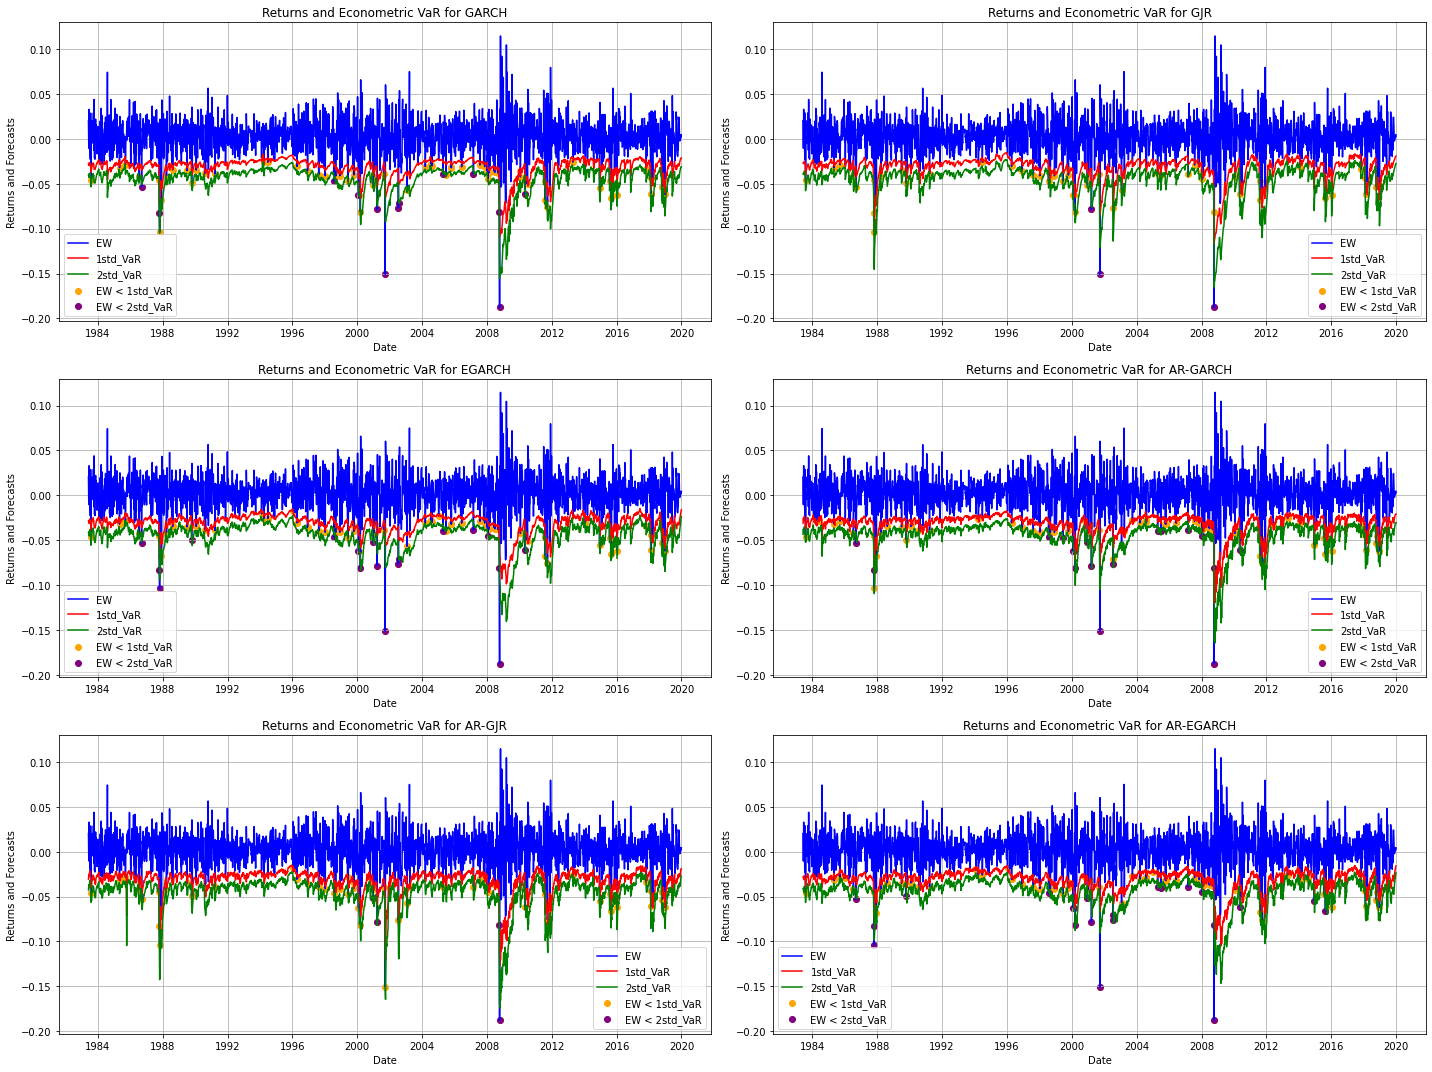

In [23]:
# Calculate the number of models
num_models = len(var_dataframes)

# Create a 2x3 grid of subplots with each subplot having larger height
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

# Flatten the 2x3 grid of subplots for easy indexing
axes = axes.flatten()

# Loop through the var_dataframes dictionary and plot each model's data in a separate subplot
for i, (modelname, comp_df) in enumerate(var_dataframes.items()):
    # Select the appropriate subplot from the grid
    ax = axes[i]

    # Plot Mean, 1std_VaR, and 2std_VaR on the current subplot
    ax.plot(comp_df.index, comp_df['EW'], label='EW', color='blue')
    ax.plot(comp_df.index, comp_df['1std_VaR'], label='1std_VaR', color='red')
    ax.plot(comp_df.index, comp_df['2std_VaR'], label='2std_VaR', color='green')

    # Highlight values in EW that are below 1std_VaR and 2std_VaR on the current subplot
    below_1std_VaR = comp_df[comp_df['EW'] < comp_df['1std_VaR']]
    below_2std_VaR = comp_df[comp_df['EW'] < comp_df['2std_VaR']]
    ax.scatter(below_1std_VaR.index, below_1std_VaR['EW'], color='orange', label='EW < 1std_VaR')
    ax.scatter(below_2std_VaR.index, below_2std_VaR['EW'], color='purple', label='EW < 2std_VaR')

    ax.set_xlabel('Date')
    ax.set_ylabel('Returns and Forecasts')
    ax.set_title(f'Returns and Econometric VaR for {modelname}')
    ax.legend()
    ax.grid(True)

# Adjust the layout and display the subplots
plt.tight_layout()
plt.show()

In [24]:
# Implied ES at 0.05
print(f"Implied ES at 0.05: {np.mean(log_portfolio_set_weekly['EW'][log_portfolio_set_weekly['EW'] < np.quantile(log_portfolio_set_weekly['EW'], 0.05)])}")

# Implied ES at 0.01
print(f"Implied ES at 0.01: {np.mean(log_portfolio_set_weekly['EW'][log_portfolio_set_weekly['EW'] < np.quantile(log_portfolio_set_weekly['EW'], 0.01)])}")

Implied ES at 0.05: -0.04647124071266191
Implied ES at 0.01: -0.07710351506071252


In [25]:
coverage_rates = pd.DataFrame(columns=['1std_VaR', '2std_VaR', '1std_ES', '2std_ES'])

for key, df in var_dataframes.items():
    coverage_rates.loc[key, ['1std_VaR', '2std_VaR']] = [len(df[df['EW']< df['1std_VaR']]) / len(df),  len(df[df['EW']< df['2std_VaR']]) / len(df)]
    coverage_rates.loc[key, ['1std_ES', '2std_ES']] = [np.mean(df['EW'][df['EW'] < df['1std_VaR']]), np.mean(df['EW'][df['EW'] < df['2std_VaR']])]

In [26]:
coverage_rates

,1std_VaR,2std_VaR,1std_ES,2std_ES
GARCH,0.040335,0.00681,-0.049655,-0.079234
GJR,0.027763,0.001572,-0.053064,-0.138933
EGARCH,0.042954,0.009429,-0.04819,-0.075606
AR-GARCH,0.04505,0.009429,-0.048048,-0.071487
AR-GJR,0.033002,0.002095,-0.051186,-0.09973
AR-EGARCH,0.046621,0.011524,-0.046874,-0.072002


***
## Model Evaluation

### Coverage

In [27]:
def coverage_test(model, q):
    
    if q == 0.05:
        hits = (var_dataframes[model]['EW'] < var_dataframes[model]['1std_VaR']).astype(int)
    elif q == 0.01:
        hits = (var_dataframes[model]['EW'] < var_dataframes[model]['2std_VaR']).astype(int)
    else:
        raise ValueError("Condition not met for q") 


    observed_hits = np.sum(hits)
    expected_hits = q * len(hits)

    std_hits = np.sqrt(q * (1 - q) * len(hits))
    z_score = (observed_hits - expected_hits) / std_hits

    p_value = 2 * stats.norm.cdf(-np.abs(z_score))

    return p_value

In [28]:
coverage_test_df = pd.DataFrame(columns=['0.05', '0.01'])
for key, value in var_dataframes.items(): 
    coverage_test_df.loc[key, :] = [coverage_test(key, 0.05), coverage_test(key, 0.01)]
coverage_test_df

,0.05,0.01
GARCH,0.052682,0.161254
GJR,0.000008,0.000215
EGARCH,0.157818,0.802023
AR-GARCH,0.321008,0.802023
AR-GJR,0.000655,0.000518
AR-EGARCH,0.498187,0.503253


### Independence

In [29]:
def independence_test(model, q):
    if q == 0.05:
        hits = (var_dataframes[model]['EW'] < var_dataframes[model]['1std_VaR']).astype(int)
    elif q == 0.01:
        hits = (var_dataframes[model]['EW'] < var_dataframes[model]['2std_VaR']).astype(int)
    else:
        raise ValueError("Condition not met for q")
    
    pvalue = runstest_1samp(hits, correction=False)[1]
    return pvalue

In [30]:
independence_test_df = pd.DataFrame(columns=['0.05', '0.01'])

for key, value in var_dataframes.items(): 
    independence_test_df.loc[key, :] = [independence_test(key, 0.05), independence_test(key, 0.01)]

independence_test_df

,0.05,0.01
GARCH,0.020901,0.0
GJR,0.002649,0.939955
EGARCH,0.052149,0.0
AR-GARCH,0.0954,0.039098
AR-GJR,0.16667,0.0
AR-EGARCH,0.141056,0.0


***
## Conclusions 

1. The AR-EGARCH seems to be the best model in terms of VaR coverage 
2. Most models fail the independence tests
3. Due to the lack of support for multivariate models in Python, we will continue the project within the R framework. 